# Import

In [1]:
from tqdm.auto import tqdm
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

/Users/nicolapitzalis/anaconda3/envs/hlt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load

In [32]:
PATH_DATA = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/ingredients_list_10k.csv'
PATH_LABELS = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/labels_10k.csv'
PATH_VOCABULARY = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/ingredients_v_10k.csv'
PATH_RECIPES = '/Users/nicolapitzalis/Documents/uni-ai/HLT/HLT-Project/dataset/recipes_df_10k.csv'

data = pd.read_csv(PATH_DATA, low_memory=False)
vocabulary = pd.read_csv(PATH_VOCABULARY)
labels = pd.read_csv(PATH_LABELS)

In [9]:
# recipes = pd.read_csv(PATH_RECIPES)
# labels = recipes['Vegetarian&Desserts']
# labels.to_csv(PATH_LABELS, index=False)

# Preprocessing

In [33]:
vocabulary = vocabulary.fillna('Missing')
ohe_vocabulary = pd.get_dummies(vocabulary, prefix='category').astype(int)  # Replace '0' with the actual column name if it exists

In [34]:
# Initialize an empty list to hold the one-hot encoded recipes
ohe_matrix = []

# Loop over each recipe in the data
for index, recipe in data.iterrows():
    # Initialize a one-hot encoded array for the recipe
    ohe_recipe = np.zeros(len(ohe_vocabulary.columns))
    
    # Loop over each ingredient in the recipe
    for ingredient in recipe:
        if pd.isnull(ingredient):
            continue
        
        # Check if the ingredient is in the one-hot vocabulary
        if f'category_{ingredient}' in ohe_vocabulary.columns:
            # Find the index for the ingredient
            ingredient_index = ohe_vocabulary.columns.get_loc(f'category_{ingredient}')
            
            # Set the corresponding position in ohe_recipe to 1
            ohe_recipe[ingredient_index] = 1

    # Append the one-hot encoded recipe to the matrix
    ohe_matrix.append(ohe_recipe)

# Convert the list of arrays into a 2D NumPy array
ohe_matrix = np.array(ohe_matrix)

In [35]:
labels = labels['Vegetarian&Desserts'].to_numpy()

# Classification

In [36]:
X_train, X_test, y_train, y_test = train_test_split(ohe_matrix, labels, test_size=0.3, random_state=42, stratify=labels)

In [37]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 6670, 1: 3330}


In [38]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4669, 1: 2331}


In [39]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2001, 1: 999}


## Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

In [31]:
random_forest = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=42, max_depth=512, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy: 0.7806666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2001
           1       0.75      0.51      0.61       999

    accuracy                           0.78      3000
   macro avg       0.77      0.71      0.73      3000
weighted avg       0.78      0.78      0.77      3000

Accuracy Score: 0.7806666666666666


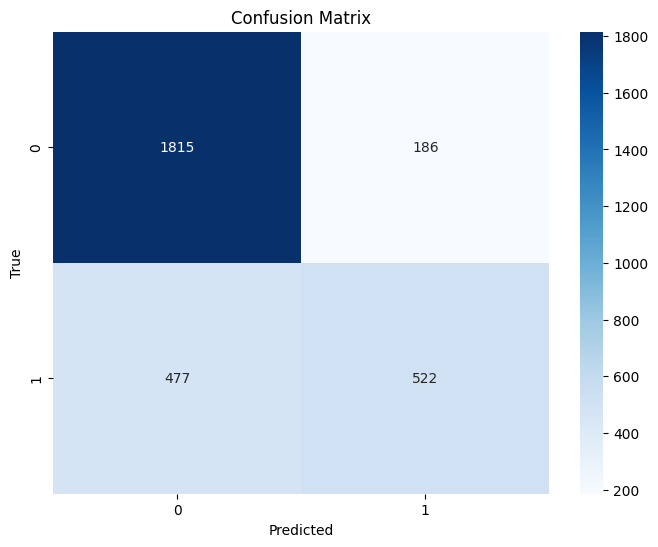

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for i, tree in enumerate(random_forest.estimators_):
    tree_rules = export_text(tree, feature_names=list(ohe_vocabulary.columns))
    
    print(f"Rules for tree {i}:\n")
    print(tree_rules)
    print("\n")

## RBM + classifier

In [ ]:
rbm = BernoulliRBM(random_state=42, verbose=True)
logistic = LogisticRegression(max_iter=1000)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

param_grid = {
    'rbm__learning_rate': [0.01, 0.1, 0.5],
    'rbm__n_iter': [20, 40, 80],
    'rbm__n_components': [50, 100, 200]  # number of hidden units
}

grid_search = GridSearchCV(classifier, param_grid, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


In [23]:
rbm = BernoulliRBM(n_components=30, learning_rate=0.1, n_iter=40, random_state=42, verbose=True)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                    solver='adam', verbose=10, random_state=21, learning_rate_init=0.01)

classifier = Pipeline(steps=[('rbm', rbm), ('mlp', mlp)])
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


[BernoulliRBM] Iteration 1, pseudo-likelihood = -139.67, time = 13.64s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -123.24, time = 16.38s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -120.18, time = 16.98s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -110.96, time = 16.44s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -108.53, time = 16.65s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -115.59, time = 16.78s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -115.24, time = 17.58s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -111.52, time = 17.38s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -116.46, time = 18.90s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -111.98, time = 18.65s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -110.23, time = 16.66s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -109.55, time = 16.82s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -106.03, time = 17.22s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -110.06, time = 16.44s
[

/Users/nicolapitzalis/anaconda3/envs/hlt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicolapitzalis/anaconda3/envs/hlt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nicolapitzalis/anaconda3/envs/hlt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

## MLP

In [29]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50,), max_iter=300, alpha=0.0001,
                    solver='adam', verbose=10, random_state=21, learning_rate_init=0.01)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Iteration 1, loss = 0.48430473
Iteration 2, loss = 0.14063719
Iteration 3, loss = 0.03345985
Iteration 4, loss = 0.01433499
Iteration 5, loss = 0.00927571
Iteration 6, loss = 0.00925149
Iteration 7, loss = 0.00835786
Iteration 8, loss = 0.00827397
Iteration 9, loss = 0.00812076
Iteration 10, loss = 0.00793096
Iteration 11, loss = 0.00842178
Iteration 12, loss = 0.00759969
Iteration 13, loss = 0.00780899
Iteration 14, loss = 0.00755681
Iteration 15, loss = 0.00764158
Iteration 16, loss = 0.00769967
Iteration 17, loss = 0.00733142
Iteration 18, loss = 0.00761851
Iteration 19, loss = 0.00721492
Iteration 20, loss = 0.00734141
Iteration 21, loss = 0.00720889
Iteration 22, loss = 0.00724683
Iteration 23, loss = 0.00716859
Iteration 24, loss = 0.00710091
Iteration 25, loss = 0.00693553
Iteration 26, loss = 0.00740660
Iteration 27, loss = 0.00722255
Iteration 28, loss = 0.00686683
Iteration 29, loss = 0.00752283
Iteration 30, loss = 0.00729117
Iteration 31, loss = 0.00740041
Iteration 32, los

Confusion Matrix:
[[1694  307]
 [ 400  599]]


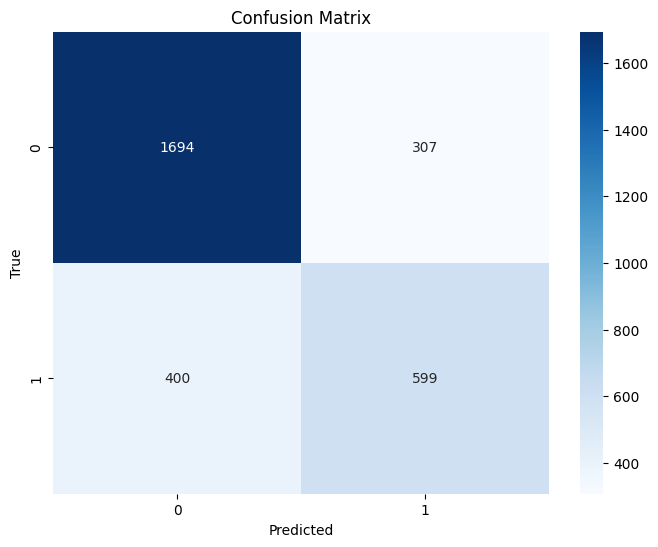

In [25]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## SVM

In [169]:
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 3/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 2/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 4/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................[CV 4/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................

[CV 1/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 1/5; 3/8] START C=10, gamma=0.001, kernel=rbf...............................
[CV 2/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 5/5; 2/8] START C=1, gamma=0.0001, kernel=rbf...............................
[CV 5/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 3/5; 1/8] START C=1, gamma=0.001, kernel=rbf................................
[CV 2/5; 3/8] START C=10, gamma=0.001, kernel=rbf

In [26]:
svc = SVC(C=100, kernel='rbf', gamma=0.001)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85      2001
           1       0.75      0.49      0.59       999

    accuracy                           0.78      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.77      0.78      0.76      3000



Confusion Matrix:
[[1841  160]
 [ 512  487]]


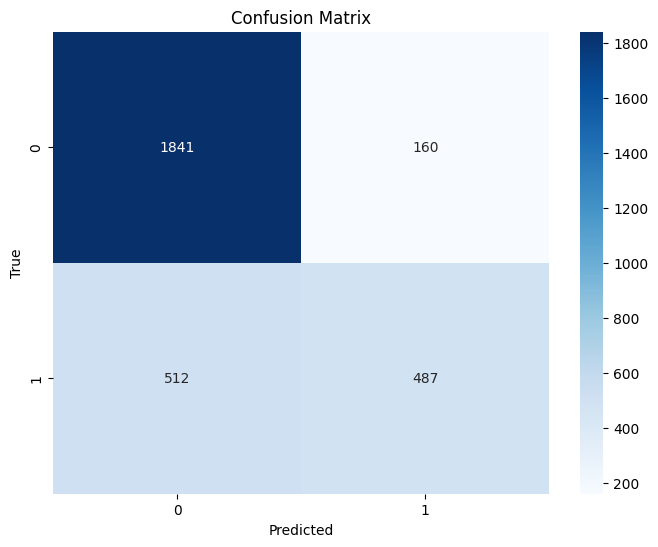

In [28]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()